In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import scipy
import re


#Pickling
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import matplotlib.style as ms
import librosa.display
import IPython.display as ipd
import seaborn
ms.use('seaborn-muted')
%matplotlib inline

x_train = []
y_train = []
x_test = []
y_test = []
no_alignment_file = [4764,3977]

In [43]:
def get_gender(text):
    text = text[len(text)-4]
    if('F' in text):
        return 'F'
    elif('M' in text):
        return 'M'
    else:
        return 'N/A'
    
def get_word_segments(align_file):
    segments = []
    try:
        with open(align_file,'r') as openFile:
            read_lines = openFile.readlines()
            lines = read_lines[1:len(read_lines)-1]
            for line in lines:
                splitted = line.split()
                segments.append({'sf': splitted[0], 'ef':splitted[1],'seg_scr':splitted[2],'word':splitted[3]})
    except Exception as e:
        print('Problem with file ',align_file)
    return segments

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    return text.lower().strip()

def play_audio(filename):
    y, sr = librosa.load(filename)
    return ipd.Audio(data=y,rate=sr)

def play_audio(filename,start,end):
    y, sr = librosa.load(filename)
    return ipd.Audio(data= y[start:end], rate=sr)
    
def generate_word_df():
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    alignment = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_alignments_path = temp_root + forced_alignment
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    for line in openFile.readlines():
                        if(line.startswith('[')):
                            line = line.split()
                            key = line[3]
                            emotion = line[4]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        for conversation in conversations:
            files_path = temp_conversations_path+ conversation
            alignments_path = temp_alignments_path + conversation
            files = os.listdir(files_path)
            for file in files:
                key,suf = file.split('.')
                if(suf == 'wav'):
                    data[key].append(files_path + '/'+ file)
                    data[key].append(alignments_path + '/'+key+'.wdseg')
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path','alignment_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    full = full.reset_index()
    full['gender'] = full['index'].apply(get_gender)
    return full

In [3]:
data = generate_word_df()
cleaned_text = clean_text(data['text'][83])
get_word_segments(data['alignment_path'][83])

[{'ef': '20', 'seg_scr': '381695', 'sf': '0', 'word': '<s>'},
 {'ef': '59', 'seg_scr': '-153170', 'sf': '21', 'word': 'YEAH'},
 {'ef': '92', 'seg_scr': '-453931', 'sf': '60', 'word': 'SO'},
 {'ef': '114', 'seg_scr': '-90507', 'sf': '93', 'word': '<sil>'},
 {'ef': '297', 'seg_scr': '-611174', 'sf': '115', 'word': '++LAUGHTER++'},
 {'ef': '308', 'seg_scr': '16490', 'sf': '298', 'word': "HE'S"},
 {'ef': '361', 'seg_scr': '234060', 'sf': '309', 'word': '<sil>'},
 {'ef': '392', 'seg_scr': '-9751', 'sf': '362', 'word': 'CALLING'},
 {'ef': '400', 'seg_scr': '7236', 'sf': '393', 'word': 'ME(2)'},
 {'ef': '437', 'seg_scr': '463996', 'sf': '401', 'word': 'NOW'},
 {'ef': '455', 'seg_scr': '17557', 'sf': '438', 'word': '</s>'}]

In [111]:
# cleaned_text.split(' ')

['yeah', 'so', '[laughter]', "he's", 'calling', 'me', 'now']

In [4]:
y,sr = librosa.load(data.wav_path[83])
y.shape

(100878,)

In [5]:
silence = ['<sil>']
actions = ['++garbage++','++breathing++', '++laughter++','++lipsmack++']
word_data = []
start_data = []
end_data = []
data3 = []
data4 = []
for index,sentence_row in data.iterrows():
    word_segments = get_word_segments(sentence_row['alignment_path'])
    if(len(word_segments) > 0):
        word_segments.pop() #REMOVE </s>
        word_segments.pop(0) #REMOVE <s>
        text_tokens = clean_text(sentence_row['text']).split(' ')
        token_index = 0
        for wordsg in word_segments:
            word = wordsg['word'].lower().split('(')[0]
            if(word in silence):
                'There is a silence here'
            elif(word in actions):
                action = word
                token_index += 1
#                 print('ACTION',word)
            else:
                word_data.append(word)
                start_data.append(wordsg['sf'])
                end_data.append(wordsg['ef'])
                 
                if(word != text_tokens[token_index]):
                    print('ERROR')
                    print(word)
                    print(text_tokens[token_index])
                    print(text_tokens)
                    print(index)
                    break
                token_index += 1
    else:
        print(index)
    if(index > 10):
        break
    

In [16]:
word_seg = get_word_segments(data.iloc[4736]['alignment_path'])
frames = map(lambda x: (x['sf'],x['ef']),word_seg)
word_seg

[{'ef': '21', 'seg_scr': '853854', 'sf': '0', 'word': '<s>'},
 {'ef': '33', 'seg_scr': '694354', 'sf': '22', 'word': '<sil>'},
 {'ef': '44', 'seg_scr': '-193190', 'sf': '34', 'word': 'OH'},
 {'ef': '135', 'seg_scr': '4121714', 'sf': '45', 'word': '<sil>'},
 {'ef': '156', 'seg_scr': '44848', 'sf': '136', 'word': 'GOD'},
 {'ef': '178', 'seg_scr': '-223703', 'sf': '157', 'word': '<sil>'},
 {'ef': '184', 'seg_scr': '-115814', 'sf': '179', 'word': 'YOU'},
 {'ef': '193', 'seg_scr': '237677', 'sf': '185', 'word': '<sil>'},
 {'ef': '196', 'seg_scr': '3842', 'sf': '194', 'word': 'ARE(2)'},
 {'ef': '216', 'seg_scr': '112366', 'sf': '197', 'word': 'DAMN'},
 {'ef': '226', 'seg_scr': '-174014', 'sf': '217', 'word': '<sil>'},
 {'ef': '251', 'seg_scr': '-676835', 'sf': '227', 'word': 'CHEAP'},
 {'ef': '270', 'seg_scr': '486566', 'sf': '252', 'word': '<sil>'},
 {'ef': '281', 'seg_scr': '-359203', 'sf': '271', 'word': 'CHEAP'},
 {'ef': '343', 'seg_scr': '-709460', 'sf': '282', 'word': '<sil>'},
 {'ef':

In [17]:
play_audio(data.iloc[4736]['wav_path'])


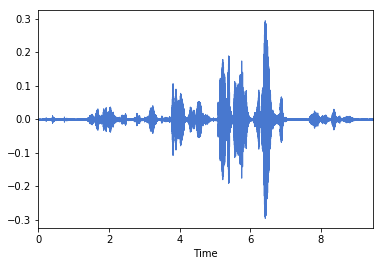

In [19]:
y, sr = librosa.load(data.iloc[4736]['wav_path'])
librosa.display.waveplot(y, sr=sr)

In [73]:
frame_size = int(frames[len(frames)-1][1])
rate = len(y) / frame_size
start = int(frames[18][0])* rate
end = int(frames[18][1]) * rate


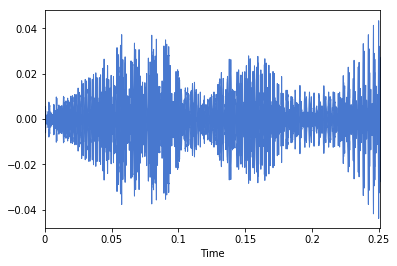

In [74]:
librosa.display.waveplot(y[start:end], sr=sr)

In [75]:
play_audio(data.iloc[4736]['wav_path'],start,end)


In [33]:
y.shape

(209072,)